In [1]:
!pip install -U seaborn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn import datasets
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

np.random.seed(5)

# Data Preparation

In [2]:
data = pd.read_csv('inpatientCharges.csv')

In [3]:
data.columns = ['DRG','Provider_Id', 'Provider_Name','Provider_StreetAddress','Provider_City',
               'Provider_State','Provider_Zipcode','Hospital_referral_region_desp',
                'Total_Discharges','Average_Covered_Charges','Average_Total_Payments',
                'Average_Medicare_Payment']

In [4]:
data['DRG'] = data['DRG'].astype('category')
data['Provider_State'] = data['Provider_State'].astype('category')
data['Provider_City'] = data['Provider_City'].astype('category')
data['Provider_Id'] = data['Provider_Id'].astype('category')
data['Average_Covered_Charges'] = (data['Average_Covered_Charges']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data['Average_Total_Payments'] = (data['Average_Total_Payments']
                              .str.replace(r'[^-+\d.]', '').astype(float))
data['Average_Medicare_Payment'] = (data['Average_Medicare_Payment']
                              .str.replace(r'[^-+\d.]', '').astype(float))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: The default value of regex will change from True to False in a future version.
  # Remove the CWD from sys.path while we load stuff.


I decide to keep my features from last assignment. However, instead of using mean as benchmark, I adapted median to robust my features against outliers.

In [5]:
benchmark = data.groupby(['Provider_State','DRG'])['Average_Total_Payments'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Payment_ByStateDRG']
benchmark.head()
feature1 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature1['ratio_amount1'] = feature1.Average_Total_Payments / feature1.Avg_Payment_ByStateDRG
feature1.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Avg_Payment_ByStateDRG,ratio_amount1
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,5658.33,1.021015
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,5658.33,1.022841
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,5658.33,0.960522
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,5658.33,0.957449
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,5658.33,1.000000


In [6]:
data['Patient_pay'] =data.Average_Total_Payments - data.Average_Medicare_Payment
benchmark = data.groupby(['Provider_State','DRG'])['Patient_pay'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Patient_Payment_ByStateDRG']
benchmark.head()
feature2 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature2['ratio_amount2'] = feature2.Patient_pay / feature2.Avg_Patient_Payment_ByStateDRG
feature2.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Avg_Patient_Payment_ByStateDRG,ratio_amount2
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,803.365,0.915487
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,803.365,1.714837
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,803.365,2.048882
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,803.365,1.013923
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,803.365,0.812009


In [7]:
data['Diff_between_patient_and_medicare_pay'] =data.Average_Medicare_Payment - data.Patient_pay
benchmark = data.groupby(['Provider_State','DRG'])['Diff_between_patient_and_medicare_pay'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_difference_in_patient_and_medicare_Payment_ByStateDRG']
benchmark.head()
feature3 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature3['ratio_amount3'] = feature3.Diff_between_patient_and_medicare_pay / feature3.Avg_difference_in_patient_and_medicare_Payment_ByStateDRG
feature3.head()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Avg_difference_in_patient_and_medicare_Payment_ByStateDRG,ratio_amount3
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,5777.24,4763.73,1013.51,3750.22,3472.63,1.079937
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,5787.57,4976.71,810.86,4165.85,3472.63,1.199624
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,5434.95,4453.79,981.16,3472.63,3472.63,1.000000
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,5417.56,4129.16,1288.40,2840.76,3472.63,0.818043
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,5658.33,4851.44,806.89,4044.55,3472.63,1.164694


In [8]:
data['Payment_over_covered_ratio'] =data.Average_Total_Payments/data.Average_Covered_Charges
benchmark = data.groupby(['Provider_State','DRG'])['Payment_over_covered_ratio'].median().reset_index()
benchmark.columns = ['Provider_State','DRG','Avg_Payment_over_covered_ratio_ByStateDRG']
benchmark.head()
feature4 = pd.merge(data, benchmark, how='left', on=['Provider_State','DRG'])
# ratio
feature4['ratio_amount4'] = feature4.Payment_over_covered_ratio / feature4.Avg_Payment_over_covered_ratio_ByStateDRG
feature4.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Avg_Payment_over_covered_ratio_ByStateDRG,ratio_amount4
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,2335.92,0.144668,0.225312,0.642079
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,1272.08,0.185552,0.225312,0.823533
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,2412.36,0.145811,0.225312,0.647148
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,6033.99,0.265406,0.225312,1.177947
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,2235.07,0.235324,0.225312,1.044436


In [9]:
data['Out_of_Pocket_ratio'] =data.Patient_pay/data.Average_Total_Payments
benchmark = data.groupby(['Hospital_referral_region_desp','DRG'])['Out_of_Pocket_ratio'].median().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Avg_Out_of_Pocket_ratio_ByRegionDRG']
benchmark.head()
feature5 = pd.merge(data, benchmark, how='left', on=['Hospital_referral_region_desp','DRG'])
# ratio
feature5['ratio_amount5'] = feature5.Out_of_Pocket_ratio / feature5.Avg_Out_of_Pocket_ratio_ByRegionDRG
feature5.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Out_of_Pocket_ratio,Avg_Out_of_Pocket_ratio_ByRegionDRG,ratio_amount5
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,2335.92,0.144668,0.193196,0.193196,1.000000
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,1272.08,0.185552,0.342070,0.188083,1.818716
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,2412.36,0.145811,0.288551,0.193196,1.493567
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,6033.99,0.265406,0.106295,0.182380,0.582824
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,2235.07,0.235324,0.184290,0.182380,1.010473


In [13]:
data.Hospital_referral_region_desp.value_counts()

CA - Los Angeles     3653
MA - Boston          2910
GA - Atlanta         2630
TX - Houston         2577
PA - Philadelphia    2554
                     ... 
OR - Bend              85
OR - Salem             85
WI - Neenah            83
ND - Grand Forks       80
ND - Minot             64
Name: Hospital_referral_region_desp, Length: 306, dtype: int64

Grouping by Referral region seem to provide small size for denominator. With the smaller denominator, the ratio will be more sensitive to outliers.

In [10]:
data['Patinet_pay_over_covered'] =data.Patient_pay/data.Average_Covered_Charges
benchmark = data.groupby(['Hospital_referral_region_desp','DRG'])['Patinet_pay_over_covered'].median().reset_index()
benchmark.columns = ['Hospital_referral_region_desp','DRG','Avg_Patinet_pay_over_covered']
benchmark.head()
feature6 = pd.merge(data, benchmark, how='left', on=['Hospital_referral_region_desp','DRG'])
# ratio
feature6['ratio_amount6'] = feature6.Patinet_pay_over_covered / feature6.Avg_Patinet_pay_over_covered
feature6.tail()

,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,Average_Total_Payments,Average_Medicare_Payment,Patient_pay,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Out_of_Pocket_ratio,Patinet_pay_over_covered,Avg_Patinet_pay_over_covered,ratio_amount6
163060,948 - SIGNS & SYMPTOMS W/O MCC,670041,SETON MEDICAL CENTER WILLIAMSON,201 SETON PARKWAY,ROUND ROCK,TX,78664,TX - Austin,23,26314.39,3806.86,3071.39,735.47,2335.92,0.144668,0.193196,0.027949,0.034718,0.805041
163061,948 - SIGNS & SYMPTOMS W/O MCC,670055,METHODIST STONE OAK HOSPITAL,1139 E SONTERRA BLVD,SAN ANTONIO,TX,78258,TX - San Antonio,11,21704.72,4027.36,2649.72,1377.64,1272.08,0.185552,0.342070,0.063472,0.040151,1.580839
163062,948 - SIGNS & SYMPTOMS W/O MCC,670056,SETON MEDICAL CENTER HAYS,6001 KYLE PKWY,KYLE,TX,78640,TX - Austin,19,39121.73,5704.36,4058.36,1646.00,2412.36,0.145811,0.288551,0.042074,0.034718,1.211875
163063,948 - SIGNS & SYMPTOMS W/O MCC,670060,TEXAS REGIONAL MEDICAL CENTER AT SUNNYVALE,231 SOUTH COLLINS ROAD,SUNNYVALE,TX,75182,TX - Dallas,11,28873.09,7663.09,6848.54,814.55,6033.99,0.265406,0.106295,0.028211,0.040339,0.699365
163064,948 - SIGNS & SYMPTOMS W/O MCC,670068,TEXAS HEALTH PRESBYTERIAN HOSPITAL FLOWER MOUND,4400 LONG PRAIRIE ROAD,FLOWER MOUND,TX,75028,TX - Dallas,12,15042.00,3539.75,2887.41,652.34,2235.07,0.235324,0.184290,0.043368,0.040339,1.075098


In [12]:
data['ratio_amount1']=feature1['ratio_amount1']
data['ratio_amount2']=feature2['ratio_amount2']
data['ratio_amount3']=feature3['ratio_amount3']
data['ratio_amount4']=feature4['ratio_amount4']
data['ratio_amount5']=feature5['ratio_amount5']
data['ratio_amount6']=feature6['ratio_amount6']

data.head()


,DRG,Provider_Id,Provider_Name,Provider_StreetAddress,Provider_City,Provider_State,Provider_Zipcode,Hospital_referral_region_desp,Total_Discharges,Average_Covered_Charges,...,Diff_between_patient_and_medicare_pay,Payment_over_covered_ratio,Out_of_Pocket_ratio,Patinet_pay_over_covered,ratio_amount1,ratio_amount2,ratio_amount3,ratio_amount4,ratio_amount5,ratio_amount6
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,...,3750.22,0.175264,0.175432,0.030747,1.021015,0.971875,1.079937,0.817735,0.995540,1.124531
1,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10005,MARSHALL MEDICAL CENTER SOUTH,2505 U S HIGHWAY 431 NORTH,BOAZ,AL,35957,AL - Birmingham,14,15131.85,...,4165.85,0.382476,0.140104,0.053586,1.022841,0.777550,1.199624,1.784531,0.759423,2.051369
2,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10006,ELIZA COFFEE MEMORIAL HOSPITAL,205 MARENGO STREET,FLORENCE,AL,35631,AL - Birmingham,24,37560.37,...,3472.63,0.144699,0.180528,0.026122,0.960522,0.940854,1.000000,0.675127,0.978540,1.000000
3,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10011,ST VINCENT'S EAST,50 MEDICAL PARK EAST DRIVE,BIRMINGHAM,AL,35235,AL - Birmingham,25,13998.28,...,2840.76,0.387016,0.237819,0.092040,0.957449,1.235472,0.818043,1.805713,1.289084,3.523433
4,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10016,SHELBY BAPTIST MEDICAL CENTER,1000 FIRST STREET NORTH,ALABASTER,AL,35007,AL - Birmingham,18,31633.27,...,4044.55,0.178873,0.142602,0.025508,1.000000,0.773743,1.164694,0.834572,0.772966,0.976473


# PCA

In [22]:
x = data.iloc[:, -6:]
x.isna().value_counts()
#There is no missing value within features

ratio_amount1  ratio_amount2  ratio_amount3  ratio_amount4  ratio_amount5  ratio_amount6
False          False          False          False          False          False            163065
dtype: int64

In [23]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
x = data.iloc[:, -6:]
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x)

pca = PCA()
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

,0,1,2,3,4,5
0,-0.329406,-0.315539,-0.378236,-0.215871,0.239428,0.201460
1,0.031139,1.041822,1.875565,-0.333431,0.415012,0.532383
2,-0.408758,-0.814288,-0.537518,-0.175171,0.237987,0.228148
3,2.189217,0.548530,2.390090,-0.710759,1.244049,0.767023
4,-0.842371,-0.266841,-0.280003,-0.207809,0.217082,0.363828


In [25]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([0.45925887, 0.28202825, 0.1622813 , 0.05389969, 0.02439459,
       0.0181373 ])

PCA 1 and 2 explain 46%+28% = 74% of the toal variance

In [26]:
x_pca.columns = ['PC1','PC2','PC3','PC4','PC5','PC6']
x_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.329406,-0.315539,-0.378236,-0.215871,0.239428,0.201460
1,0.031139,1.041822,1.875565,-0.333431,0.415012,0.532383
2,-0.408758,-0.814288,-0.537518,-0.175171,0.237987,0.228148
3,2.189217,0.548530,2.390090,-0.710759,1.244049,0.767023
4,-0.842371,-0.266841,-0.280003,-0.207809,0.217082,0.363828


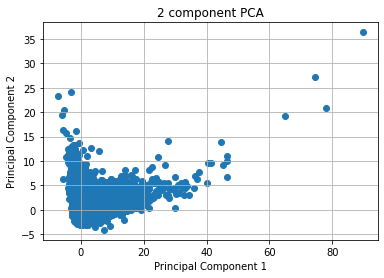

In [27]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1') 
ax.set_ylabel('Principal Component 2') 
ax.set_title('2 component PCA') 
ax.scatter(x_pca.loc[:, 'PC1'], x_pca.loc[:, 'PC2'])
ax.grid()


While there is no Y variable, from the scatterplot of pca 1 and 2, we can see there are some outliers clustering.
40 seems to be a good cutoff point for PC1 and 15 seems to be a good cutoff for PC2. 

# KNn

In [28]:
!pip install pyod
!pip install --upgrade pip
!pip install sklearn
from sklearn import model_selection
from pyod.models.knn import KNN

In [54]:
x['Y'] = 0
X = x.iloc[:, -7:-1]
Y = x['Y']
X.head()

,0,1,2,3,4,5
0,-0.140595,-0.254384,0.104237,-0.605240,-0.183811,-0.014224
1,-0.131961,-0.459772,0.454669,1.726180,-0.592490,1.185192
2,-0.426662,-0.287171,-0.129809,-0.949138,-0.213235,-0.175379
3,-0.441196,0.024220,-0.662559,1.777262,0.324266,3.090180
4,-0.239973,-0.463796,0.352397,-0.564637,-0.569050,-0.205825


I decided to use 70/30 classic train/test split to maintain to maintain sufficient representation on the test-dataset

In [55]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.3, random_state=42)

In [56]:
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)
y_train_scores = clf.decision_scores_

In [59]:
y_test_pred = clf.predict(X_test)
unique, counts = np.unique(y_test_pred, return_counts=True)
dict(zip(unique, counts))
y_test_scores = clf.decision_function(X_test)

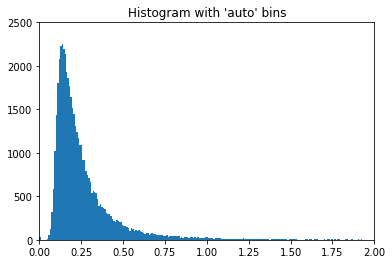

In [60]:
import matplotlib.pyplot as plt
plt.hist(y_test_scores, bins = 'auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.axis([0, 2,0,2500])
plt.show()

I decided to have the cutoff point at 1.1. This is because the distribution becomes almost invisible beyond 1.1.

In [61]:

df_test = pd.DataFrame(X_test)
df_test['score'] = y_test_scores
df_test['cluster'] = np.where(df_test['score']<1.1, 0, 1)
df_test.groupby('cluster').mean()

,0,1,2,3,4,5,score
cluster,,,,,,,
0,-0.040323,-0.072902,0.012416,-0.019218,-0.057840,-0.058186,0.247830
1,2.092038,4.275885,-0.706177,1.140154,3.631479,3.733566,2.073731


In [62]:
df_test['cluster'].value_counts()

0    48095
1      825
Name: cluster, dtype: int64

Two clusters seem to make good sense as the average score/distance for cluster 0 is only .25 while the average score/distance for cluster1(outlier cluster) is almost 8x bigger. Cluster size seem to make sense with sufficient amount of outliers compare to the normal-data.

# Iteration to reduce overfitting

For the purpose to reducing overfitting, I decided to run iterations over 5k-NN models

In [44]:
x['Y'] = 0
X = x.iloc[:, -7:-1]
Y = x['Y']
X.head()

,0,1,2,3,4,5
0,-0.140595,-0.254384,0.104237,-0.605240,-0.183811,-0.014224
1,-0.131961,-0.459772,0.454669,1.726180,-0.592490,1.185192
2,-0.426662,-0.287171,-0.129809,-0.949138,-0.213235,-0.175379
3,-0.441196,0.024220,-0.662559,1.777262,0.324266,3.090180
4,-0.239973,-0.463796,0.352397,-0.564637,-0.569050,-0.205825


In [45]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=.3, random_state=42)

In [46]:
!pip install combo
from pyod.models.combination import aom, moa, average, maximization
from pyod.utils.utility import standardizer
# Standardize data
X_train_norm, X_test_norm = standardizer(X_train, X_test)
# Test a range of k-neighbors from 10 to 50. There will be 5 k-NN models.
n_clf = 5
k_list = [10, 20, 30, 40, 50]
# Just prepare data frames so we can store the model results
train_scores = np.zeros([X_train.shape[0], n_clf])
test_scores = np.zeros([X_test.shape[0], n_clf])
train_scores.shape
# Modeling
for i in range(n_clf):
    k = k_list[i]
    clf = KNN(n_neighbors=k, method='largest')
    clf.fit(X_train_norm)

# Store the results in each column:
train_scores[:, i] = clf.decision_scores_
test_scores[:, i] = clf.decision_function(X_test_norm) 
# Decision scores have to be normalized before combination
train_scores_norm, test_scores_norm = standardizer(train_scores,test_scores)

# Using average aggregating method

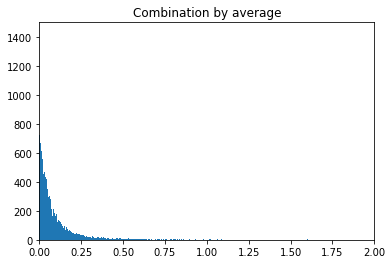

In [49]:
y_by_average = average(test_scores_norm)
import matplotlib.pyplot as plt
plt.hist(y_by_average, bins='auto')
plt.title("Combination by average")
plt.axis([0, 2,0,1500])
plt.show()

The cutoff after iteration seems a lot smaller than before. I decided .5 would be a reasonable point.

In [50]:
df_test = pd.DataFrame(X_test)
df_test['y_by_average_score'] = y_by_average
df_test['y_by_average_cluster'] = np.where(df_test['y_by_average_score']<.5, 0, 1)
df_test['y_by_average_cluster'].value_counts()

0    48386
1      534
Name: y_by_average_cluster, dtype: int64

In [51]:
df_test.groupby('y_by_average_cluster').mean()


,0,1,2,3,4,5,y_by_average_score
y_by_average_cluster,,,,,,,
0,-0.032776,-0.056348,0.007170,-0.016278,-0.041541,-0.043270,-0.011696
1,2.570208,5.145802,-0.622441,1.505556,4.165047,4.448315,1.071657


While the average score & distance for cluster 0 is negative, we can interpret it as the distance betwee the data points in cluser 0 is very small- close to 0. The magnitude of the distance gap between points in cluster 1 seem to be lower. However, if we compare score of cluster 0 (close to 0) to closer 1, the difference actually amplified.
Comparing to the result from average aggregation to the sample Knn model, the cutoff point seem to be a smaller- showing the reduction of overfitting. The size of anomoly cluster is reduced after aggregating with average method, and the magnitude of scores also seem less extreme. However, the score does still show enough evidence that cluster 1 contain anomoly data/outliers. 